# Inference and Spherical Coding

This notebook demonstrates the basic idea of Spherical Coding in compressing trajectory data on the NGSIM-101 dataset.

## Load the trajectory data, as usual

In [1]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
y_vec = np.array(trajs['y_vec'])
t_vec = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file

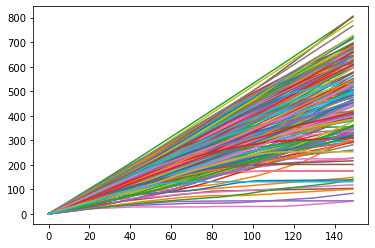

In [2]:
for traj in range(y_vec.shape[0]):
    plt.plot(y_vec[traj])

This is the sample trajectory dataset

Let's generate exemplary observations stream

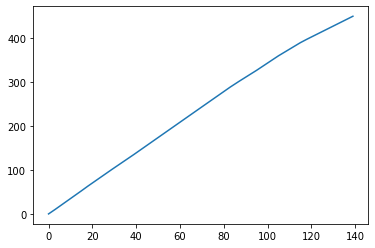

In [3]:
y_test = y_vec[8,:140]
plt.plot(y_test)

## Let's try Spline basis first

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


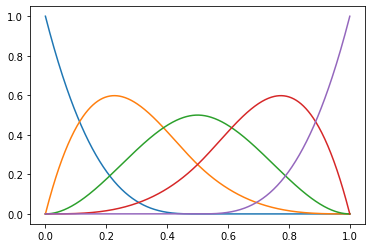

In [4]:
import skfda

# Spline basis
n_basis = 5
basis = skfda.representation.basis.BSpline(n_basis=n_basis)
basis.plot()

Convert data to the spline basis

In [5]:
fdgry = skfda.FDataGrid(y_vec, t_vec)
fdgry_in_splines = fdgry.to_basis(basis)
y_coeffs = fdgry_in_splines.coefficients
friendly_basis = np.zeros((n_basis, t_vec.shape[0]))
for i in range(n_basis):
    friendly_basis[i,:] = fdgry_in_splines.basis.evaluate(t_vec)[i].reshape(-1)

## Learning the prior distribution

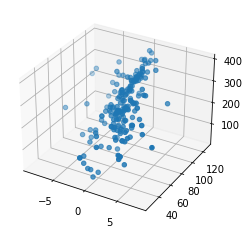

In [6]:
# Visualizing the first three components
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(y_coeffs[:,0], y_coeffs[:,1], y_coeffs[:,2])

In [7]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bandwidth_candidates = 10 ** np.linspace(1,10,100) # 10^x from -1 to 1
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidth_candidates}, cv=LeaveOneOut())
grid.fit(y_coeffs)
#kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(y_coeffs)
#plt.hist(kde.score_samples(y_coeffs))

GridSearchCV(cv=LeaveOneOut(), estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.00000000e+01, 1.23284674e+01, 1.51991108e+01, 1.87381742e+01,
       2.31012970e+01, 2.84803587e+01, 3.51119173e+01, 4.32876128e+01,
       5.33669923e+01, 6.57933225e+01, 8.11130831e+01, 1.00000000e+02,
       1.23284674e+02, 1.51991108e+02, 1.87381742e+02, 2.31012970e+02,
       2.84803587e+02, 3.511191...
       8.11130831e+07, 1.00000000e+08, 1.23284674e+08, 1.51991108e+08,
       1.87381742e+08, 2.31012970e+08, 2.84803587e+08, 3.51119173e+08,
       4.32876128e+08, 5.33669923e+08, 6.57933225e+08, 8.11130831e+08,
       1.00000000e+09, 1.23284674e+09, 1.51991108e+09, 1.87381742e+09,
       2.31012970e+09, 2.84803587e+09, 3.51119173e+09, 4.32876128e+09,
       5.33669923e+09, 6.57933225e+09, 8.11130831e+09, 1.00000000e+10])})

In [8]:
kde = KernelDensity(kernel='gaussian', bandwidth=15.12).fit(y_coeffs)

In [9]:
# Save the KDE so that we don't have to learn from the data the next time the algorithm is run
with open('kde.pyo', 'wb') as f:
    pickle.dump(kde, f, pickle.HIGHEST_PROTOCOL)
print('The file has been saved successfully!')

The file has been saved successfully!


In [11]:
from scipy.stats import norm 
def likelihood(z, theta, t):
    reconstructed_trajectory = theta.T @ friendly_basis 
    #print('Mean: ', reconstructed_trajectory[t])
    #print('Test: ', z)
    #raise Exception("LALALA")
    return norm.pdf(z, loc=reconstructed_trajectory[t], scale=3.0) # scale is the std

In [12]:
# Low variance resampling
def lvr(particles, weights): # requires normalized weights first
    # return: new particles with equal weights
    M = particles.shape[0] # number of particles
    new_particles = np.zeros_like(particles)
    # new_particles_weight = np.ones((M,)) / M 
    # W = np.sum(weights)
    r = np.random.rand() / M # get a random number between 0 and 1/M
    c = weights[0]
    i = 0
    for m in range(M):
        U = r + m/M
        while U>c:
            i+=1
            c+=weights[i]
        new_particles[m] = particles[i]
    return new_particles


## Spherical codes

### Determining the lattice size

First we find the size of the distribution lattice, which is a 5D sphere with diameter 1m. As a consequence, all representation points belonging to the same lattice should not give an error larger than 1m. The following code demonstrates the idea.

Note that for B-spline basis, the maximum value of the basis value is already 1, so any representation vector whose norm is at most 1 will give an error at most 1m. 

The precise formula is:

$ ||a|| = \frac{h_{max}}{\max_t \Phi(t)} $

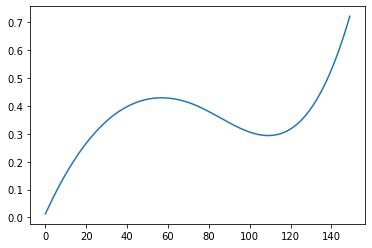

In [14]:
delta_betwn_two_pts = np.random.rand(5,)
delta_betwn_two_pts = delta_betwn_two_pts / np.linalg.norm(delta_betwn_two_pts)
error_in_time_domain = delta_betwn_two_pts.reshape((1,5)) @ friendly_basis
plt.plot(error_in_time_domain[0])

So the error stays less than 1m. As we predicted.

### Relative Inferential Spherical Coding (RISC)

First of all, the whole idea is similar to delta compression: as the estimation of the representation vector $a$ gets better with observations arriving, we will subsequently broadcast the change to other vehicles, which is the delta compared to the last estimate. All MAP estimates start from the prior's mean $\overline{a}$, then gradually moves to the corresponding generating representation vector $a^*$.

Encoding the radial component should be simple: we send a 1 if we want to move to the next annulus of lattice in the outward radial direction. We send a 0 if we want to move in inward radial direction. Overall, the less common the trajectory is, the more bits we have to send (in multiple attempts) to other vehicles. Vice-versa, because most trajectories can be represented close to the mean, we expect to send little bits to determine the "correct" annulus $a^*$ is in.

In [15]:
from scipy.stats import norm 
from coding import huffman
import sys 

In [17]:
def angular_minus(a,b):
    d = np.mod(a - b, np.pi * 2)
    return (d > np.pi) * (np.pi * 2 - d) + (d <= np.pi) * d

In [140]:
n_particles = 5000 
map_particle_available = False

# Step 1: generate a bunch of particles from the prior distribution
particles = kde.sample(n_particles, random_state=6969)
weights = np.ones((n_particles,)) / n_particles
map_components_log = np.zeros((y_test.shape[0], particles.shape[1]))
weights_variance_log = np.zeros((y_test.shape[0],))
measurement_likelihood_log = np.zeros((y_test.shape[0],))
error_log = np.zeros((y_test.shape[0],))
broadcast_log = np.zeros((y_test.shape[0],))
bits_log = []

lattice_size = 1/np.sqrt(np.shape(particles[0])[0]) # 1/sqrt(5) in case of 5 basis components

for t in range(y_test.shape[0]):
    # When measurement arrives, calculate the importance weights first
    weights_normalization_coeff = 0
    for j in range(weights.shape[0]):
        measurement_likelihood = likelihood(y_test[t], particles[j,:], t)
        weights[j] = measurement_likelihood
        weights_normalization_coeff += weights[j]
        measurement_likelihood_log[t] += measurement_likelihood

    # print(t, measurement_likelihood)

    # Normalization all the weights
    for j in range(weights.shape[0]):
        weights[j] = weights[j] / weights_normalization_coeff
    
    if not map_particle_available: # first assignment of map_particle_value
        # Get the index of the particle with largest weight, that will be our maximum-a-posteriori estimate 
        map_particle_index = np.argmax(weights)
        map_particle_value = particles[map_particle_index]
        mean_particle = map_particle_value.copy()
        map_components_log[t,:] = map_particle_value
        map_particle_available = True

        # Intialization of variables at the beginning of the inference process
        alpha = np.zeros_like(mean_particle)
        # alphac = np.zeros_like(alpha)
        beta = np.zeros((np.shape(mean_particle)[0]-1,))
        beta_mean = beta.copy() # this is the smoothed out mean of the beta vector using beta in the past for which we will use to build the Huffman's probability table 
        beta_sd = np.ones_like(beta_mean) * np.pi / 4 # this is the variance vector to accompany with the mean vector above
        betaq = np.zeros_like(beta)
        rq = 0 
        phi = np.zeros_like(beta)
        phiq = np.zeros_like(beta)
        
        
    error_log[t] = np.abs(((map_particle_value) @ friendly_basis)[t] - y_test[t])
    map_particle_index = np.argmax(weights)
    map_particle_value_new = particles[map_particle_index]
    
    if error_log[t] > 2.0: # if the prediction from MAP deviates up to 2ft from the actual observations
        # we will have to broadcast an update so that our fellows can adjust accordingly
        alpha_new = map_particle_value_new - mean_particle
        delta = alpha_new - alpha 
        
        # calculating radial component
        delta_r = np.linalg.norm(delta) # change in radius
        delta_rq = np.floor(delta_r / lattice_size) # quantized change in radius
        delta_rc = delta_rq * lattice_size # reconstructed change in radius 
        r_bits = delta_rq
        if delta_rc == 0: 
            delta_rc = 1
            r_entropy = 1
        else:
            r_entropy = np.log2(delta_rc) 


        # calculating the spherical coordinates (i.e., the beta vector)
        beta_new = np.zeros((np.shape(mean_particle)[0]-1,))
        for dimension in range(np.shape(mean_particle)[0]-1):
            # formula for spherical coordinates (first 3 components)
            beta_new[dimension] = np.arccos(delta[dimension]/np.linalg.norm(delta[dimension:]))
        # spherical coordinate for the final component
        if delta[-1] >= 0:
            beta_new[-1] = np.arccos(delta[-2]/np.linalg.norm(delta[-2:]))
        else:
            beta_new[-1] = 2 * np.pi - np.arccos(delta[-2]/np.linalg.norm(delta[-2:]))

        # quantizing the spherical coordinates
        number_of_lattices = np.floor(2 * np.pi * delta_rc / lattice_size) + 1
        phi_new = np.zeros_like(beta_new)
        betac_new = np.zeros_like(phi_new)
        for dimension in range(np.shape(mean_particle)[0]-1):
            phi_new[dimension] = np.floor(delta_rc * beta_new[dimension] / lattice_size) # to be encoded with Huffman
            betac_new[dimension] = phi_new[dimension] * lattice_size / delta_rc # to be used with rc to reconstruct the alphac vector

        # reconstruct the alpha vector (the thing our clients will get)
        deltac = np.zeros_like(alpha_new)
        for i in range(np.shape(mean_particle)[0]-1):
            v = delta_rc
            for k in range(i):
                v = v * np.sin(betac_new[k])
            v = v * np.cos(betac_new[i])  
            deltac[i] = v 
        deltac[-1] = deltac[-2] / np.cos(betac_new[-1]) * np.sin(betac_new[-1])

        # print('Delta distance: {} ({})'.format(deltac - delta, np.linalg.norm(deltac - delta)))
        alphac_new = alpha + deltac # this is what our client will get
        # print('Alpha distance: ', np.linalg.norm(alphac_new - alpha_new))

        # encode the phi_new vector 
        phi_entropy = 0
        phi_bits = np.zeros_like(phi_new)
        phi_prob = np.zeros_like(phi_bits)
        for dimension in range(np.shape(mean_particle)[0]-1):
            # first, we need to create a probability table to derive Huffman's code
            if number_of_lattices < 2: # ensure there will be a minimum of 2 lattices to encode
                p_lattice = np.ones((2,))
            else:
                p_lattice = np.zeros((int(number_of_lattices),))
            for i in range(int(number_of_lattices)):
                p_lattice[i] = norm.pdf(angular_minus(2 * np.pi / number_of_lattices * i, beta_mean[dimension]), 0, beta_sd[dimension])
            if np.linalg.norm(p_lattice) < 1e-2:
                p_lattice = np.ones_like(p_lattice) # preventing p_lattice from being too small
            p_lattice = p_lattice / np.linalg.norm(p_lattice)
            # generate the Huffman code (see Useful Snippet 1 below)
            p_lattice_sort_arg = np.argsort(p_lattice)[::-1]
            p_lattice_sorted = p_lattice[p_lattice_sort_arg]
            p_lattice_sort_map = np.argsort(p_lattice_sort_arg)
            # generate 
            code = huffman.HuffmanCode(p_lattice_sorted.tolist())
            spherical_code = code.compute_code()

            for index, s in enumerate(spherical_code):
                if s == '':
                    spherical_code[index] = '0'

            phi_prob[dimension] = p_lattice_sorted[p_lattice_sort_map[int(phi_new[dimension])]]
            phi_bits[dimension] = int(spherical_code[p_lattice_sort_map[int(phi_new[dimension])]], 2) # convert a string of binary to int
            if phi_bits[dimension]<1e-2:
                phi_bits[dimension] += 0
            else:
                phi_entropy += np.log2(phi_bits[dimension])

        # Update beta_mean and beta_sd
        angular_dist = angular_minus(betac_new, beta_mean)
        beta_mean = 0.3 * beta_mean + 0.7 * betac_new 
        beta_sd = 0.7 * np.abs(angular_dist) + 0.3 * beta_sd

        if np.isinf(phi_bits).any():
            raise Exception('NaN in phi_bits')

        # print('Radial/angular delta vector: {} / {}'.format(r_bits, phi_bits))
        print('Ang dist btwn trans (deg): {}'.format(angular_dist / np.pi * 180))
        print('Rad bits / Ang bits: {:.2f}/{:.2f}'.format(r_entropy, phi_entropy))
        print('W/O bef/aft cmpr: {:.0f} -> {:.0f} ({:.2f}%) bits'.format(5 * 32, r_entropy + phi_entropy, (r_entropy + phi_entropy) / (5 * 64) * 100))
        print('--- END OF TRANSMISSION ATTEMPT ---')
        map_components_log[t,:] = map_particle_value
        broadcast_log[t] = 1
        bits_log.append(r_entropy + phi_entropy)

        # Assign new values to current values
        # map_particle_value = map_particle_value_new_c.copy() # should reconstruct alpha from quantized parameters and place it here
        alpha = alphac_new.copy()
        beta = betac_new.copy() # reconstructed from quantization 
        phi = phi_new.copy()  # reconstructed from quantization too

        # sys.exit()
    
    # Resample the particles according to the particle weights
    if measurement_likelihood_log[t] < 100:
        particles = lvr(particles, weights)
        weights = np.ones((n_particles,)) / n_particles

    weights_variance_log[t] = np.var(weights)

Ang dist btwn trans (deg): [88.6807288  77.00260814 20.43671116 13.30579276]
Rad bits / Ang bits: 6.13/34.53
W/O bef/aft cmpr: 160 -> 41 (12.71%) bits
--- END OF TRANSMISSION ATTEMPT ---
Ang dist btwn trans (deg): [ 23.86715911  67.20061737  47.76472999 125.92409137]
Rad bits / Ang bits: 5.88/70.83
W/O bef/aft cmpr: 160 -> 77 (23.97%) bits
--- END OF TRANSMISSION ATTEMPT ---
Ang dist btwn trans (deg): [ 13.34143515  34.61228904  15.26057447 105.44539452]
Rad bits / Ang bits: 7.75/38.17
W/O bef/aft cmpr: 160 -> 46 (14.35%) bits
--- END OF TRANSMISSION ATTEMPT ---
Ang dist btwn trans (deg): [ 0.40284214 28.6117397  21.57446989 37.63964327]
Rad bits / Ang bits: 7.37/33.25
W/O bef/aft cmpr: 160 -> 41 (12.70%) bits
--- END OF TRANSMISSION ATTEMPT ---
Ang dist btwn trans (deg): [  2.57115213  10.85076898  46.84816205 171.75479714]
Rad bits / Ang bits: 7.93/50.63
W/O bef/aft cmpr: 160 -> 59 (18.30%) bits
--- END OF TRANSMISSION ATTEMPT ---
Ang dist btwn trans (deg): [  3.48446727  11.01517582

Mean (STD): 41.07 (+-32.77)


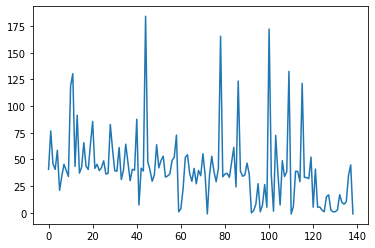

In [141]:
plt.plot(np.array(bits_log))
print('Mean (STD): {:.2f} (+-{:.2f})'.format(np.average(np.array(bits_log)), np.std(np.array(bits_log))))

In [143]:
np.sum(bits_log) / ((32 * 5) * 150)

0.2378485342488612

## Useful snippets

This snippet shows how to find the original probability value after we have sorted the probability to produce the Huffman's Code.

In [36]:
a = np.array([3,1,4,2])
a_arg = np.argsort(a)[::-1]
a_arg2 = np.argsort(a_arg)
a_descending = a[a_arg]
a_descending[a_arg2[1]]

1

## Debugging

In [139]:
spherical_code

['', '10', '110', '1110', '11110', '111110', '111111']

In [131]:
alphac_new

array([ 1.61654472, 15.78708353, 64.09065259, 23.24076173, -5.49636434])